In [52]:
#Dan's Notes: ordinal encoding for  Utilities as follows : 4-AllPub 3-NoSewr 2-NoSeWa 1-ELO
# ordinal encoding for OverallQual & OverallCond & ExterQual & ExterCond & BsmtQual & BsmtCond as per condition 

#here we are attempting the encoding method of ordinal encoding vs traiditional label encoding
#we are comparing the accuracy results for different models with different hyper-parameters (check the CV section for variations in hyper parameters)





In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ABDO.PreProcess import PreProcessing

In [54]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [55]:
pre=PreProcessing()

In [56]:
data=pd.read_csv(r'C:\Users\ritam\Documents\playground\Scripts\house-prices-advanced-regression-techniques\train.csv')


In [57]:
 data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA 

<Figure size 2000x1000 with 0 Axes>

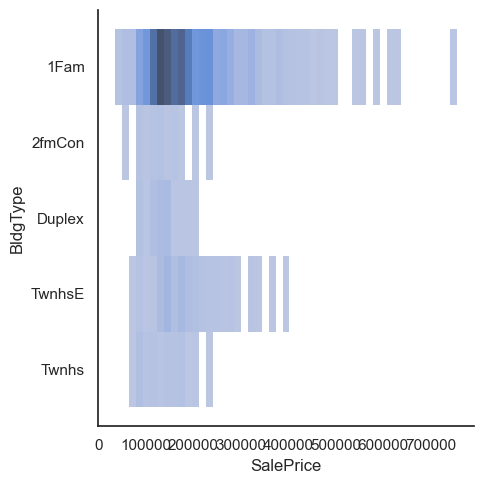

In [58]:
plt.figure(figsize=(20,10))

sns.displot(data,x='SalePrice', y='BldgType',kind='hist')

<Axes: xlabel='SalePrice', ylabel='YearBuilt'>

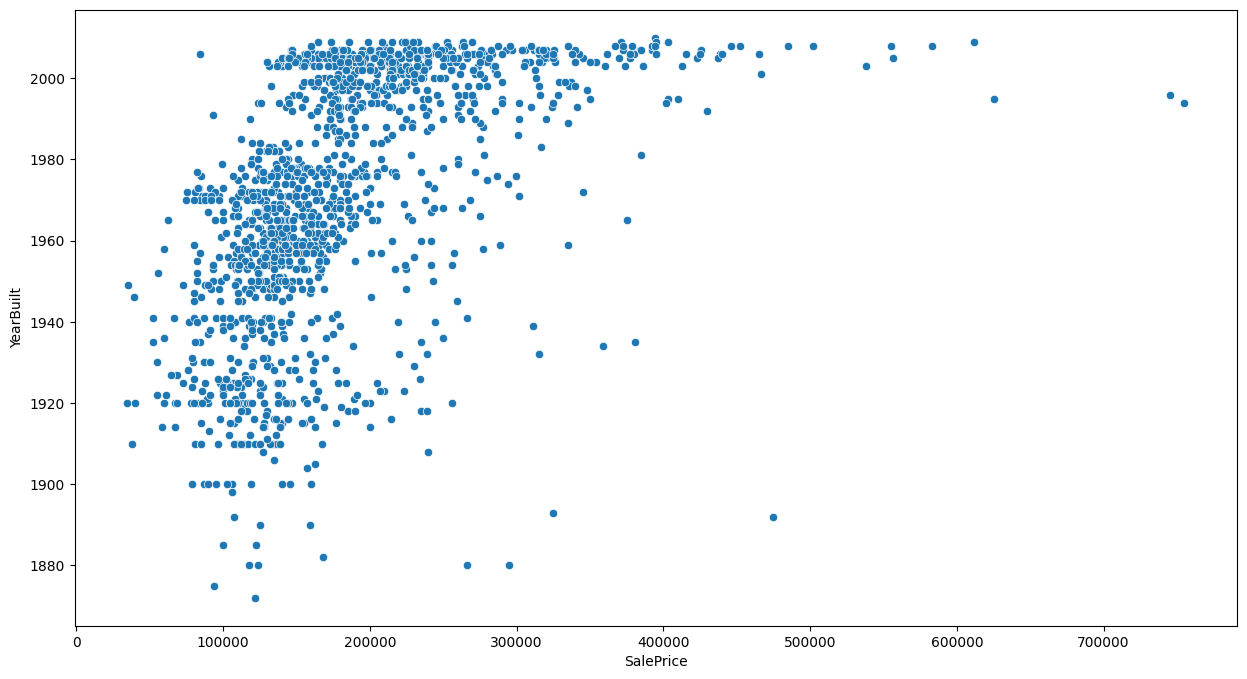

In [14]:

plt.figure(figsize=(15,8))
sns.scatterplot(data,x='SalePrice',y='YearBuilt')

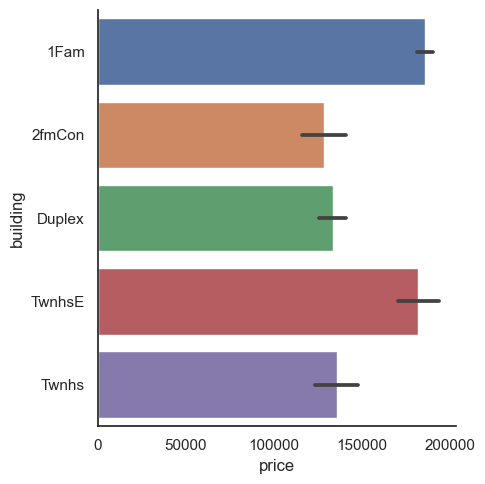

In [59]:
sns.set(style="white",)
g = sns.catplot(x='SalePrice',
                y= 'BldgType',
                #hue='BldgType',
                data=data,
                kind='bar',
                #ci=None,
                   )
g.set_axis_labels("price", "building")
plt.show()

In [60]:
data.SalePrice.corr(data[''])

KeyError: ''

In [61]:
data.isna().value_counts().index[0]

(False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False)

In [149]:
#sale condition & sale type are ordinal 
#foundation &  are nominal 
#featrue engineering to calculate total house, garage, basement, lot areas
Condition2={}
Condition2={'Feedr':1,
       'Norm':2,
       'RRNn':3,
       'RRAn':4,
       'PosN':5,
       'PosA':6,
       'RRNe':7,
       'RRAe':8}

In [150]:
#Target encoding 
SaleCondDict={}
SaleCondDict={'Normal':6,
        'Abnorml':4,
        'Partial':5,
        'AdjLand':1,
        'Alloca':3,
        'Family':2
    }

In [151]:
#Target encoding 
SaleTypeDict={}
SaleTypeDict={'WD':9,
              'New':8,
              'COD':7,
              'ConLD':6,
              'ConLI':5,
              'CWD':4,
              'ConLw':2, 
              'Con':3,
              'Oth':1
             }


In [152]:
FoundationDict={}
FoundationDict={'PConc':6, 
                'CBlock':5, 
                'BrkTil':4, 
                'Wood':1, 
                'Slab':3,
                'Stone':2}

In [153]:
Condition1: 
       ['Artery',
       'Feedr',
       'Norm',
       'RRNn',
       'RRAn',
       'PosN',
       'PosA',
       'RRNe',
       'RRAe']


SyntaxError: invalid syntax (2851875553.py, line 1)

In [113]:
Exterior1st={'AsbShng':1,
       'AsphShn':2,
       'BrkComm':3,
       'BrkFace':4,
       'CBlock':5,
       'CemntBd':6,
       'HdBoard':7,
       'ImStucc':8,
       'MetalSd':9,
       'Other':10,
       'Plywood':11,
       'PreCast':12,
       'Stone':13,
       'Stucco':14,
       'VinylSd':15,
       'Wd Sdng':16,
       'WdShing':17 }


In [134]:
OED1={'Feedr':1,
       'Norm':2,
       'RRNn':3,
       'RRAn':4,
       'PosN':5,
       'PosA':6,
       'RRNe':7,
       'RRAe':8}
OED2={'AsbShng':1,
       'AsphShn':2,
       'BrkComm':3,
       'BrkFace':4,
       'CBlock':5,
       'CemntBd':6,
       'HdBoard':7,
       'ImStucc':8,
       'MetalSd':9,
       'Other':10,
       'Plywood':11,
       'PreCast':12,
       'Stone':13,
       'Stucco':14,
       'VinylSd':15,
       'Wd Sdng':16,
       'WdShing':17 }

OED3={ 'Feedr':1,
       'Norm':2,
       'RRNn':3,
       'RRAn':4,
       'PosN':5,
       'PosA':6,
       'RRNe':7,
       'RRAe':8}


test.replace(OED1,inplace=True)
test
#one_hot_encoded_data1 = pd.get_dummies(test, columns = cat1.columns ,drop_first=True)
#one_hot_encoded_data1

AttributeError: 'NoneType' object has no attribute 'replace'

In [ ]:
data.info()

# Dropping columns with high number of Nan 

In [130]:
#dropping all pool related fields cause we have 1453 nan values for pool area 
#doing the same for the following columns as they had high number of nan values: 3SsnPorch PoolArea OpenPorchSF EnclosedPorch ScreenPorch WoodDeckSF
#Dropping the following columns to improve lr as they have lowest corr score to target BsmtFinSF2 0.011378 BsmtHalfBath 0.016844MiscVal 0.021190 LowQualFinSF 0.025606 YrSold 0.028923 MoSold 0.046432 OverallCond 0.077856 MSSubClass  
data.drop(['BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','YrSold','MoSold','OverallCond','MSSubClass'],axis=1,inplace=True)
# data.drop(['3SsnPorch', 'PoolArea', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF','PoolArea', 'PoolQC', 'MiscFeature', 'FireplaceQu', 'MasVnrType', 'Alley','Fence','LotFrontage'],axis=1, inplace=True)
data.head()

,Id,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,1,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,6,Gd,TA,No,GLQ,706,Unf,150,856,GasA,Ex,Y,SBrkr,856,854,1710,1,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,9,6,208500
1,2,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,5,Gd,TA,Gd,ALQ,978,Unf,284,1262,GasA,Ex,Y,SBrkr,1262,0,1262,0,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,9,6,181500
2,3,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,6,Gd,TA,Mn,GLQ,486,Unf,434,920,GasA,Ex,Y,SBrkr,920,866,1786,1,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,9,6,223500
3,4,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,4,TA,Gd,No,ALQ,216,Unf,540,756,GasA,Gd,Y,SBrkr,961,756,1717,1,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,9,4,140000
4,5,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,6,Gd,TA,Av,GLQ,655,Unf,490,1145,GasA,Ex,Y,SBrkr,1145,1053,2198,1,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,9,6,250000


In [63]:
pre.Information(data)


 There is : 122  Nulls, Representing 0.08 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'Id': 'Continuous', 'MSSubClass': 'Continuous', 'LotArea': 'Continuous', 'OverallQual': 'Discrete', 'OverallCond': 'Discrete', 'YearBuilt': 'Continuous', 'YearRemodAdd': 'Continuous', 'MasVnrArea': 'Continuous', 'BsmtFinSF1': 'Continuous', 'BsmtFinSF2': 'Continuous', 'BsmtUnfSF': 'Continuous', 'TotalBsmtSF': 'Continuous', '1stFlrSF': 'Continuous', '2ndFlrSF': 'Continuous', 'LowQualFinSF': 'Continuous', 'GrLivArea': 'Continuous', 'BsmtFullBath': 'Discrete', 'BsmtHalfBath': 'Discrete', 'FullBath': 'Discrete', 'HalfBath': 'Discrete', 'BedroomAbvGr': 'Discrete', 'KitchenAbvGr': 'Discrete', 'TotRmsAbvGrd': 'Continuous', 'Fireplaces': 'Discrete', 'GarageYrBlt': 'Continuous', 'GarageCars': 'Discrete', 'GarageArea': 'Continuous', 'MiscVal': 'Continuous', 'MoSold': 'Continuous', 'YrSold': 'Discrete', 'SalePrice': 'Continuous'}

 Categorical Columns : {'MSZo

,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,Id,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1460,int64,0,0
1,MSSubClass,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...",15,int64,0,0
2,MSZoning,"[RL, RM, C (all), FV, RH]",5,object,0,0
3,LotArea,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,...",1073,int64,0,0
4,Street,"[Pave, Grvl]",2,object,0,0
5,LotShape,"[Reg, IR1, IR2, IR3]",4,object,0,0
6,LandContour,"[Lvl, Bnk, Low, HLS]",4,object,0,0
7,Utilities,"[AllPub, NoSeWa]",2,object,0,0
8,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5,object,0,0
9,LandSlope,"[Gtl, Mod, Sev]",3,object,0,0


In [68]:
data.SalePrice.corr(data.GrLivArea)

0.7086244776126521

In [131]:
data.Foundation.replace(FoundationDict,inplace=True)

In [132]:
data.SaleCondition.replace(SaleCondDict,inplace=True)

In [133]:
data.SaleType.replace(SaleTypeDict,inplace=True)

In [134]:
data.SaleType.head()

0    9
1    9
2    9
3    9
4    9
Name: SaleType, dtype: int64

In [135]:
#'PoolQC', 'MiscFeature', 'FireplaceQu', 'MasVnrType', 'Alley','Fence','LotFrontage'
# 'Foundation', SaleType', 'SaleCondition'
cat=pd.DataFrame(data[['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']])
#cat.head()
'''filling by highest frequency category'''
cat = cat.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat.HomePlanet.fillna(value='Mars',inplace=True)
#cat.Destination.fillna(value='PSO J318.5-22',inplace=True)
#cat.VIP.fillna(value='False',inplace=True)
cat.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y


In [136]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1460 non-null   object
 1   Street        1460 non-null   object
 2   LotShape      1460 non-null   object
 3   LandContour   1460 non-null   object
 4   Utilities     1460 non-null   object
 5   LotConfig     1460 non-null   object
 6   LandSlope     1460 non-null   object
 7   Neighborhood  1460 non-null   object
 8   Condition1    1460 non-null   object
 9   Condition2    1460 non-null   object
 10  BldgType      1460 non-null   object
 11  HouseStyle    1460 non-null   object
 12  RoofStyle     1460 non-null   object
 13  RoofMatl      1460 non-null   object
 14  Exterior1st   1460 non-null   object
 15  Exterior2nd   1460 non-null   object
 16  ExterQual     1460 non-null   object
 17  ExterCond     1460 non-null   object
 18  BsmtQual      1460 non-null   object
 19  BsmtCo

In [138]:
'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'
'BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','YrSold','MoSold','OverallCond','MSSubClass'
num=pd.DataFrame(data[[ 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']])
num = num.apply(lambda x:x.fillna(x.interpolate()))
#num.isna().value_counts()
num.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
0,8450,7,2003,2003,196.0,706,150,856,856,854,1710,1,2,1,3,1,8,0,2003.0,2,548
1,9600,6,1976,1976,0.0,978,284,1262,1262,0,1262,0,2,0,3,1,6,1,1976.0,2,460
2,11250,7,2001,2002,162.0,486,434,920,920,866,1786,1,2,1,3,1,6,1,2001.0,2,608
3,9550,7,1915,1970,0.0,216,540,756,961,756,1717,1,1,0,3,1,7,1,1998.0,3,642
4,14260,8,2000,2000,350.0,655,490,1145,1145,1053,2198,1,2,1,4,1,9,1,2000.0,3,836


In [85]:
num.columns
#'LotArea'   GarageAreav,   TotalBsmtSF, , , 
# 3SsnPorch PoolArea OpenPorchSF EnclosedPorch ScreenPorch WoodDeckSF

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [86]:
#sns.histplot(data=data, x='PoolArea',y='SalePrice')
#data.LotArea.value_counts(data[['LotArea']<=500].max())
data['GarageArea'].value_counts()

GarageArea
0      81
440    49
576    47
240    38
484    34
       ..
320     1
594     1
831     1
878     1
192     1
Name: count, Length: 441, dtype: int64

In [28]:
cat.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive'],
      dtype='object')

In [29]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   OverallCond    1460 non-null   int64  
 4   YearBuilt      1460 non-null   int64  
 5   YearRemodAdd   1460 non-null   int64  
 6   MasVnrArea     1460 non-null   float64
 7   BsmtFinSF1     1460 non-null   int64  
 8   BsmtFinSF2     1460 non-null   int64  
 9   BsmtUnfSF      1460 non-null   int64  
 10  TotalBsmtSF    1460 non-null   int64  
 11  1stFlrSF       1460 non-null   int64  
 12  2ndFlrSF       1460 non-null   int64  
 13  LowQualFinSF   1460 non-null   int64  
 14  GrLivArea      1460 non-null   int64  
 15  BsmtFullBath   1460 non-null   int64  
 16  BsmtHalfBath   1460 non-null   int64  
 17  FullBath       1460 non-null   int64  
 18  HalfBath

In [154]:
data2=pd.concat([cat,num,data['Foundation'],data['SaleType'],data['SaleCondition'],data['SalePrice']], axis=1, join='outer')
data2

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,Foundation,SaleType,SaleCondition,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,8450,7,2003,2003,196.0,706,150,856,856,854,1710,1,2,1,3,1,8,0,2003.0,2,548,6,9,6,208500
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,9600,6,1976,1976,0.0,978,284,1262,1262,0,1262,0,2,0,3,1,6,1,1976.0,2,460,5,9,6,181500
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,11250,7,2001,2002,162.0,486,434,920,920,866,1786,1,2,1,3,1,6,1,2001.0,2,608,6,9,6,223500
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,9550,7,1915,1970,0.0,216,540,756,961,756,1717,1,1,0,3,1,7,1,1998.0,3,642,4,9,4,140000
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,14260,8,2000,2000,350.0,655,490,1145,1145,1053,2198,1,2,1,4,1,9,1,2000.0,3,836,6,9,6,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,TA,TA,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,7917,6,1999,2000,0.0,0,953,953,953,694,1647,0,2,1,3,1,7,1,1999.0,2,460,6,9,6,175000
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,TA,TA,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,13175,6,1978,1988,119.0,790,589,1542,2073,0,2073,1,2,0,3,1,7,2,1978.0,2,500,5,9,6,210000
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,9042,7,1941,2006,0.0,275,877,1152,1188,1152,2340,0,2,0,4,1,9,2,1941.0,1,252,2,9,6,266500
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,TA,TA,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,9717,5,1950,1996,0.0,49,0,1078,1078,0,1078,1,1,0,2,1,5,0,1950.0,1,240,5,9,6,142125


In [155]:
data2.SalePrice.value_counts().values.max()

20

In [ ]:
data2.groupby(['''SalePrice'])

In [140]:
#num.corr()
min_correlations = correlation_matrix.min()
min_correlations
# Step 3: Identify the columns associated with these minimum correlation values
# columns_with_lowest_correlation = min_correlations.idxmin()
# columns_with_lowest_correlation
num_w_price=num.copy(deep=True)
num_w_price['SalePrice']=data['SalePrice']
correlation_matrix=num_w_price.corr()

min_correlations = abs(correlation_matrix['SalePrice']).sort_values(ascending=True)
min_correlations

KitchenAbvGr    0.135907
BedroomAbvGr    0.168213
BsmtUnfSF       0.214479
BsmtFullBath    0.227122
LotArea         0.263843
HalfBath        0.284108
2ndFlrSF        0.319334
BsmtFinSF1      0.386420
Fireplaces      0.466929
GarageYrBlt     0.467290
MasVnrArea      0.474279
YearRemodAdd    0.507101
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023033,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.074526,-0.040110,-0.098672,-0.007683,-0.013585,-0.021407
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103910,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024893,0.154871,0.180403,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.408650,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.512127,0.600671,0.562022,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127786,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.304856,-0.185758,-0.151521,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.313659,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.775012,0.537850,0.478954,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.178187,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.615723,0.420622,0.371600,-0.010286,0.021490,0.035743
MasVnrArea,0.023033,0.103910,0.408650,-0.127786,0.313659,0.178187,1.000000,0.263452,-0.072081,0.112801,0.361005,0.340734,0.176031,-0.068942,0.390527,0.085891,0.026777,0.275810,0.201068,0.104676,-0.037116,0.281308,0.250683,0.246489,0.362967,0.371416,-0.029741,-0.008351,-0.006621
BsmtFinSF1,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263452,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.157172,0.224054,0.296970,0.003571,-0.015727,0.014359
BsmtFinSF2,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072081,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.085909,-0.038264,-0.018227,0.004940,-0.015211,0.031706
BsmtUnfSF,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.112801,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.179661,0.214175,0.183303,-0.023837,0.034888,-0.041258


In [34]:
pre.Information(data2)


 There is : 0  Nulls, Representing 0.00 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'MSSubClass': 'Continuous', 'LotArea': 'Continuous', 'OverallQual': 'Discrete', 'OverallCond': 'Discrete', 'YearBuilt': 'Continuous', 'YearRemodAdd': 'Continuous', 'MasVnrArea': 'Continuous', 'BsmtFinSF1': 'Continuous', 'BsmtFinSF2': 'Continuous', 'BsmtUnfSF': 'Continuous', 'TotalBsmtSF': 'Continuous', '1stFlrSF': 'Continuous', '2ndFlrSF': 'Continuous', 'LowQualFinSF': 'Continuous', 'GrLivArea': 'Continuous', 'BsmtFullBath': 'Discrete', 'BsmtHalfBath': 'Discrete', 'FullBath': 'Discrete', 'HalfBath': 'Discrete', 'BedroomAbvGr': 'Discrete', 'KitchenAbvGr': 'Discrete', 'TotRmsAbvGrd': 'Continuous', 'Fireplaces': 'Discrete', 'GarageYrBlt': 'Continuous', 'GarageCars': 'Discrete', 'GarageArea': 'Continuous', 'WoodDeckSF': 'Continuous', 'OpenPorchSF': 'Continuous', 'EnclosedPorch': 'Continuous', '3SsnPorch': 'Continuous', 'ScreenPorch': 'Continuous', 'PoolA

,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,MSZoning,"[RL, RM, C (all), FV, RH]",5,object,0,0
1,Street,"[Pave, Grvl]",2,object,0,0
2,LotShape,"[Reg, IR1, IR2, IR3]",4,object,0,0
3,LandContour,"[Lvl, Bnk, Low, HLS]",4,object,0,0
4,Utilities,"[AllPub, NoSeWa]",2,object,0,0
5,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5,object,0,0
6,LandSlope,"[Gtl, Mod, Sev]",3,object,0,0
7,Neighborhood,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...",25,object,0,0
8,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...",9,object,0,0
9,Condition2,"[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...",8,object,0,0


# Encoding

In [157]:
one_hot_encoded_data = pd.get_dummies(data2, columns = cat.columns ,drop_first=True)
one_hot_encoded_data.head()


,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,Foundation,SaleType,SaleCondition,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y
0,8450,7,2003,2003,196.0,706,150,856,856,854,1710,1,2,1,3,1,8,0,2003.0,2,548,6,9,6,208500,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,T

In [173]:
data2=pd.concat([cat,one_hot_encoded_data], axis=1, join='outer')
#data2['Transported']=data['Transported']
data2.drop(cat.columns,axis=1, inplace=True)
data2.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,Foundation,SaleType,SaleCondition,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y
0,8450,7,2003,2003,196.0,706,150,856,856,854,1710,1,2,1,3,1,8,0,2003.0,2,548,6,9,6,208500,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,T

In [195]:
X=data2.drop('SalePrice',axis=1)
y=pd.array(data2['SalePrice'])

# Baseline Model 

In [260]:
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate,  train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


RS=42  #standerizing random_state to 42 

In [197]:
lr=LinearRegression()
rf=RandomForestRegressor()

# Train-Test-Validation Split

In [242]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 42)

In [243]:
print('x_train Shape:',x_train.shape,'y_train Shape:',y_train.shape)

x_train Shape: (1022, 199) y_train Shape: (1022,)


In [229]:
x_train=x_train.values.reshape(-1,1)
x_train

array([[10400],
       [7],
       [1970],
       ...,
       [True],
       [False],
       [True]], dtype=object)

In [245]:
lr.fit(x_train, y_train)

LinearRegression()

In [246]:
lr.score(x_train,y_train)

0.9263649943451895

In [247]:
lr.score(x_test,y_test)

0.7574563561890372

In [258]:
#x_train=x_train.values.reshape(-1,1)
lrCV= GridSearchCV(lr, lrParams, cv=10, n_jobs=3)
lrCV.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=3,
             param_grid={'copy_X': [True], 'fit_intercept': [True],
                         'n_jobs': [None], 'positive': [False]})

In [259]:
lrCV.score(x_test,y_test)

0.7574563561890372

In [254]:
y_train.reshape(1,-1)

<PandasArray>
[
[174000, 145000, 215200, 320000, 212000, 168500, 189000, 140000, 187500,
 254900,
 ...
 119000, 142500, 167000, 100000, 278000, 176432, 135000, 115000, 189950,
 174000]
]
Shape: (1, 1022), dtype: int64

In [257]:
lrCV.fit(x_train,y_train.reshape(1,-1))
lrCV.score(y_test.reshape(1,-1))

ValueError: Found input variables with inconsistent numbers of samples: [1022, 1]

In [262]:
from sklearn.metrics import mean_squared_error

# Sample data
# Create and train the XGBoost linear regression model
model = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=42)
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 904659882.6312277


In [263]:
model.score(x_test,y_test)

0.8703571614793761

# Cross Validation 

In [101]:
RS=42

In [217]:
lrParams = {
    'fit_intercept':[True],
     
    'copy_X' : [True],
    'n_jobs' : [None],
    'positive':[False]
}
rfParams = {
    'criterion': ['squared_error'],
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': range(2,5),
    'min_samples_leaf': range(5,10),
    'min_samples_split': [2,4],
    'verbose': [2],
    'n_estimators': [100],
    'random_state':[RS]
}

In [103]:
rfParams = {
    'criterion': ['squared_error'],
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': range(2,5),
    'min_samples_leaf': range(5,10),
    'min_samples_split': [2,4],
    'verbose': [2],
    'n_estimators': [100],
    'random_state':[RS]
}

In [104]:
# rfCV= GridSearchCV(rf, rfParams, cv=10, n_jobs=3)
# rfCV.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=3,
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [90, 100, 110],
                         'max_features': range(2, 5),
                         'min_samples_leaf': range(5, 10),
                         'min_samples_split': [2, 4], 'n_estimators': [100],
                         'random_state': [42], 'verbose': [2]})

In [105]:
# rfCV.best_score_

0.6904955969656235

# Submission

In [111]:
test=pd.read_csv(r'C:\Users\ritam\Documents\playground\Scripts\house-prices-advanced-regression-techniques\test.csv')


In [112]:

cat1=pd.DataFrame(test[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']])
#cat.head()
cat1 = cat1.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat.HomePlanet.fillna(value='Mars',inplace=True)
#cat.Destination.fillna(value='PSO J318.5-22',inplace=True)
#cat.VIP.fillna(value='False',inplace=True)
cat1

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
1,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Gar2,WD,Normal
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
4,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
1455,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,CarPort,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Abnorml
1456,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Abnorml
1457,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,BrkFace,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal


# cat1.info()

In [118]:
num1=pd.DataFrame(test[[ 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']])
num1 = num1.apply(lambda x:x.fillna(x.median()))
#num.isna().value_counts()
num1.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010


In [119]:
one_hot_encoded_data1 = pd.get_dummies(test, columns = cat1.columns ,drop_first=True)
one_hot_encoded_data1

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False

In [120]:
test=pd.concat([cat1,one_hot_encoded_data1], axis=1, join='outer')
test.drop(cat1.columns,axis=1, inplace=True)
test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False

In [121]:
test.drop('Id',axis=1,inplace=True)

In [42]:
test_pred=pd.DataFrame()
test_pred['SalePrice']=pd.DataFrame(rfCV.predict(test))
test_pred

NameError: name 'test' is not defined

In [82]:
pre.Information(data)


 There is : 122  Nulls, Representing 0.08 % of The Data

 There is : 0  Duplicated, Representing 0.00 % of The Data

 Numerical Columns : {'Id': 'Continuous', 'MSSubClass': 'Continuous', 'LotArea': 'Continuous', 'OverallQual': 'Discrete', 'OverallCond': 'Discrete', 'YearBuilt': 'Continuous', 'YearRemodAdd': 'Continuous', 'MasVnrArea': 'Continuous', 'BsmtFinSF1': 'Continuous', 'BsmtFinSF2': 'Continuous', 'BsmtUnfSF': 'Continuous', 'TotalBsmtSF': 'Continuous', '1stFlrSF': 'Continuous', '2ndFlrSF': 'Continuous', 'LowQualFinSF': 'Continuous', 'GrLivArea': 'Continuous', 'BsmtFullBath': 'Discrete', 'BsmtHalfBath': 'Discrete', 'FullBath': 'Discrete', 'HalfBath': 'Discrete', 'BedroomAbvGr': 'Discrete', 'KitchenAbvGr': 'Discrete', 'TotRmsAbvGrd': 'Continuous', 'Fireplaces': 'Discrete', 'GarageYrBlt': 'Continuous', 'GarageCars': 'Discrete', 'GarageArea': 'Continuous', 'WoodDeckSF': 'Continuous', 'OpenPorchSF': 'Continuous', 'EnclosedPorch': 'Continuous', '3SsnPorch': 'Continuous', 'ScreenPorch'

,Feature,Unique_Values,No.OfUniqueValues,DataType,NoOfNulls,Nulls %
0,Id,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1460,int64,0,0
1,MSSubClass,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...",15,int64,0,0
2,MSZoning,"[RL, RM, C (all), FV, RH]",5,object,0,0
3,LotArea,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,...",1073,int64,0,0
4,Street,"[Pave, Grvl]",2,object,0,0
5,LotShape,"[Reg, IR1, IR2, IR3]",4,object,0,0
6,LandContour,"[Lvl, Bnk, Low, HLS]",4,object,0,0
7,Utilities,"[AllPub, NoSeWa]",2,object,0,0
8,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5,object,0,0
9,LandSlope,"[Gtl, Mod, Sev]",3,object,0,0


In [84]:
data.SaleCondition.unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

In [116]:
data.SaleType.unique()

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
      dtype=object)

<Axes: xlabel='SalePrice', ylabel='SaleCondition'>

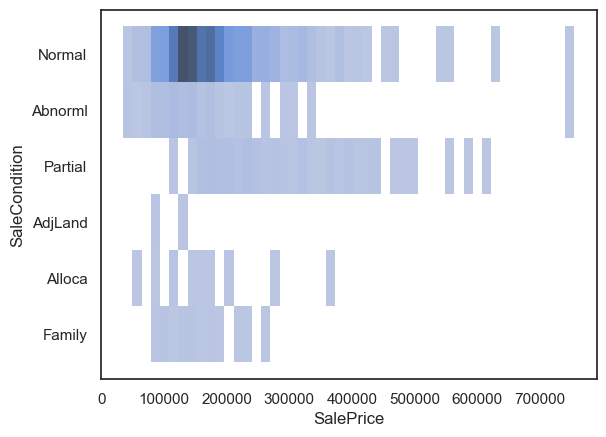

In [85]:
sns.histplot(data=data,x='SalePrice',y='SaleCondition')

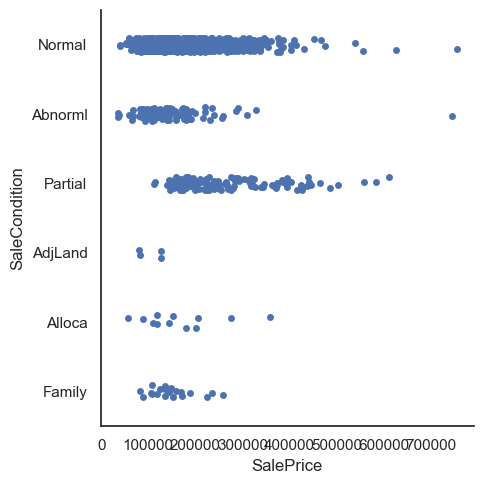

In [86]:
sns.catplot(data=data,x='SalePrice',y='SaleCondition')

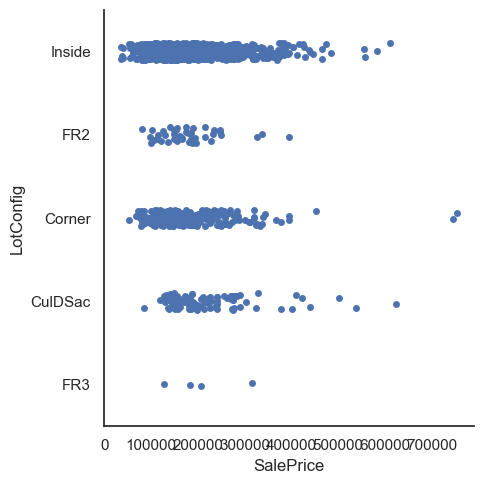

In [164]:
sns.catplot(data=data,x='SalePrice',y='LotConfig')

<Axes: xlabel='SalePrice', ylabel='LotConfig'>

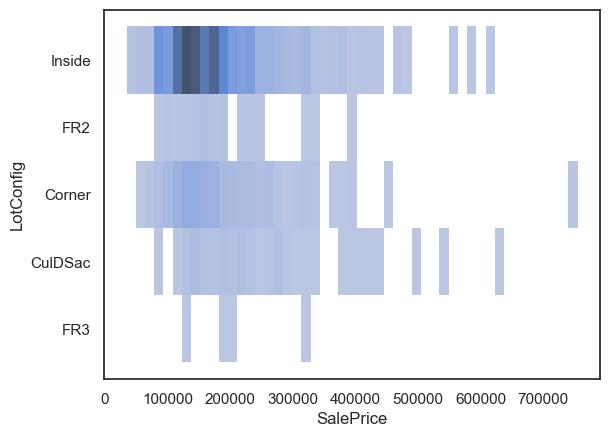

In [163]:
sns.histplot(data=data,x='SalePrice',y='LotConfig')

In [ ]:
data.BsmtFinSF2
    #BsmtFinSF2: Type 2 finished square feet BsmtUnfSF: Unfinished square feet of basement area TotalBsmtSF: total in sq feet 

In [135]:
test.replace(OED1,inplace=True)
test


AttributeError: 'NoneType' object has no attribute 'replace'

# Gradient Boosting (LGM VS XGB)

In [ ]:
from sklearn.ensemble import 

In [1]:
!pip install tensorflow_decision_forests --upgrade

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\ritam\Documents\playground\Lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\ritam\Documents\playground\Lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\ritam\Documents\playground\Lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\ritam\Documents\playground\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ritam\AppData\Local\Programs\Python\Python311\Lib\http\client.py", line 466, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\ritam\AppData\Local\Programs\Python\Pytho


     -------------------------------------- 15.2/15.2 MB 155.7 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ----                                    32.4/300.9 MB 8.3 kB/s eta 9:02:18
